## RF Classifier: Hyperparameter Tuning and Metrics for Healthy vs Pre‑Diabetic & Pre‑Diabetic vs Diabetic

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier       
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Defining Evaluation function to compute all metrics including confusion matrix, sensitivity, specificity, and per-class precision/recall.
def evaluate_model(y_true, y_pred, model_name, dataset_size, split_num, model_weights, model_biases, best_params):
    metrics = {
        'Model': model_name,
        'Dataset Size': dataset_size,
        'Split': split_num,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted'),
        'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score (Weighted)': f1_score(y_true, y_pred, average='weighted'),
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'Weights': model_weights,
        'Biases': model_biases,
        'Best Params': best_params  
    }
    # If binary classification, add sensitivity/ specificity / class-1 precision & recall
    if len(np.unique(y_true)) == 2:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        metrics.update({
            'Sensitivity (TPR)': tp / (tp + fn),
            'Specificity (TNR)': tn / (tn + fp),
            'Precision (Class 1)': precision_score(y_true, y_pred, pos_label=1),
            'Recall (Class 1)': recall_score(y_true, y_pred, pos_label=1)
        })
    return metrics

# Hyperparameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators':      [100, 200],
    'max_depth':         [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf':  [1, 2]
}

# Preparing to iterate over dataset sizes and pre-saved splits
dataset_sizes = [100000, 150000]
split_nums    = [1, 2]

# We'll still use repeated stratified folds internally for tuning
cv_splitter = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

all_results = []

# Loop for each dataset size and split number
for size in dataset_sizes:
    for split_num in split_nums:
        print(f"\n=== Dataset size: {size}, Split: {split_num} ===")
        
        # 1) Load the raw 80/20 splits (no PCA) from the "splits" folder
        train_df = pd.read_csv(os.path.join('splits', f'train_size_{size}_split_{split_num}.csv'))
        test_df  = pd.read_csv(os.path.join('splits', f'test_size_{size}_split_{split_num}.csv'))
        
        # 2) Extract feature columns (everything except the one-hot Diabetes targets)
        feature_cols = [c for c in train_df.columns if not c.startswith('Diabetes_')]
        X_train = train_df[feature_cols].values
        X_test  = test_df[feature_cols].values
        
        # 3) Healthy vs Pre-/Diabetic labels
        y_train_m1 = np.where(
            (train_df['Diabetes_1']==1) | (train_df['Diabetes_2']==1),
            1, 0
        )
        y_test_m1  = np.where(
            (test_df['Diabetes_1']==1) | (test_df['Diabetes_2']==1),
            1, 0
        )

        # 4) Instantiate RF & tune with RandomizedSearchCV on the raw training set
        rf = RandomForestClassifier(class_weight='balanced', random_state=42)         
        rs = RandomizedSearchCV(
            rf,
            param_distributions=param_dist,
            n_iter=5,               # 5 random hyperparameter combos × 10 folds = 50 fits
            cv=cv_splitter,         # repeated stratified folds on the 80% train
            scoring='f1',
            n_jobs=-1,
            verbose=2               
        )
        rs.fit(X_train, y_train_m1)
        best_rf = rs.best_estimator_
        best_params_m1 = rs.best_params_
        print("Best parameters for RF_Model1:", best_params_m1)
        
        y_pred_m1 = best_rf.predict(X_test)
        metrics_m1 = evaluate_model(
            y_test_m1, y_pred_m1,
            model_name='RF_Model1',
            dataset_size=size,
            split_num=split_num,
            model_weights=best_rf.feature_importances_,
            model_biases=None,
            best_params=best_params_m1
        )
        all_results.append(metrics_m1)
        
        # Pre-Diabetic vs Diabetic labels
        m_train = (train_df['Diabetes_1']==1) | (train_df['Diabetes_2']==1)
        m_test  = (test_df['Diabetes_1']==1) | (test_df['Diabetes_2']==1)
        
        if m_train.sum() > 0 and m_test.sum() > 0:
            X_train_m2 = train_df.loc[m_train, feature_cols].values
            y_train_m2 = np.where(train_df.loc[m_train, 'Diabetes_1']==1, 1, 0)
            X_test_m2  = test_df.loc[m_test, feature_cols].values
            y_test_m2  = np.where(test_df.loc[m_test, 'Diabetes_1']==1, 1, 0)
            
            rf2 = RandomForestClassifier(class_weight='balanced', random_state=42)     
            rs2 = RandomizedSearchCV(
                rf2,
                param_distributions=param_dist,
                n_iter=5,           # 5 random hyperparameter combos * 10 folds = 50 fits
                cv=cv_splitter,
                scoring='f1',
                n_jobs=-1,
                verbose=2
            )
            rs2.fit(X_train_m2, y_train_m2)
            best_rf2 = rs2.best_estimator_
            best_params_m2 = rs2.best_params_
            print("Best parameters for RF_Model2:", best_params_m2)
            
            y_pred_m2 = best_rf2.predict(X_test_m2)
            metrics_m2 = evaluate_model(
                y_test_m2, y_pred_m2,
                model_name='RF_Model2',
                dataset_size=size,
                split_num=split_num,
                model_weights=best_rf2.feature_importances_,
                model_biases=None,
                best_params=best_params_m2
            )
            all_results.append(metrics_m2)

# Saving results for each binary task to separate CSVs
results_df = pd.DataFrame(all_results)

# Filtering and exporting the two tasks
df_task1 = results_df[results_df['Model']=='RF_Model1']
df_task2 = results_df[results_df['Model']=='RF_Model2']
df_task1.to_csv("RF_Healthy_vs_Pre_Diabetic.csv", index=False)
df_task2.to_csv("RF_Pre_Diabetic_vs_Diabetic.csv", index=False)

print("\nSaved RF_Healthy_vs_Pre_Diabetic.csv and RF_Pre_Diabetic_vs_Diabetic.csv")



=== Dataset size: 100000, Split: 1 ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters for RF_Model1: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters for RF_Model2: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}

=== Dataset size: 100000, Split: 2 ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters for RF_Model1: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters for RF_Model2: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

=== Dataset size: 150000, Split: 1 ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters for RF_Model1: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, '

## Average Performance Metrics by Task & Dataset Size

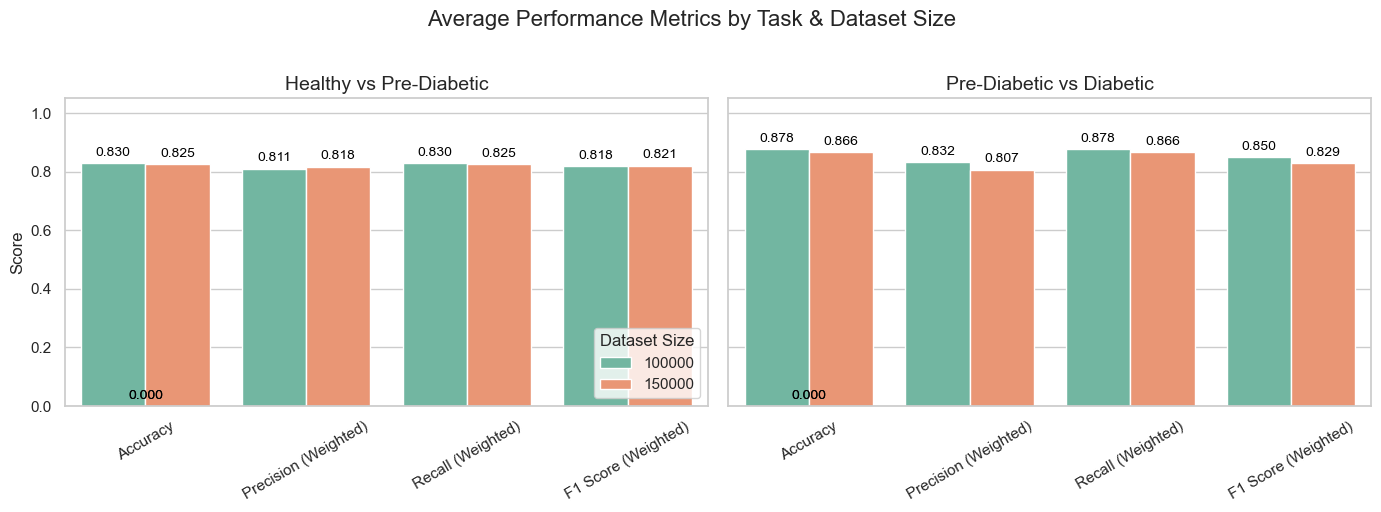

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load and tag
df1 = pd.read_csv("RF_Healthy_vs_Pre_Diabetic.csv")
df2 = pd.read_csv("RF_Pre_Diabetic_vs_Diabetic.csv")
df1['Task'] = 'Healthy vs Pre-Diabetic'
df2['Task'] = 'Pre-Diabetic vs Diabetic'
df = pd.concat([df1, df2], ignore_index=True)

# 2) Compute averages
metrics = ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1 Score (Weighted)']
avg_df = (
    df
    .groupby(['Task', 'Dataset Size'])[metrics]
    .mean()
    .reset_index()
)

# 3) Melt into long form
avg_long = avg_df.melt(
    id_vars=['Task', 'Dataset Size'],
    value_vars=metrics,
    var_name='Metric',
    value_name='Score'
)

# 4) Plot
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2", n_colors=2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, task in zip(axes, avg_long['Task'].unique()):
    sub = avg_long[avg_long['Task'] == task]
    sns.barplot(
        ax=ax,
        data=sub,
        x='Metric', 
        y='Score',
        hue='Dataset Size',
        palette=palette,
        errorbar=None    
    )
    ax.set_title(task, fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('')
    ax.set_ylabel('Score', fontsize=12)
    ax.tick_params(axis='x', rotation=30)

    # annotate bars
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(
            f"{h:.3f}",
            (p.get_x() + p.get_width() / 2, h),
            ha='center', va='bottom',
            fontsize=10, color='black',
            xytext=(0, 3), textcoords='offset points'
        )

axes[0].legend(title='Dataset Size')
axes[1].legend_.remove()

fig.suptitle("Average Performance Metrics by Task & Dataset Size", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Confusion Matrix for all RF models

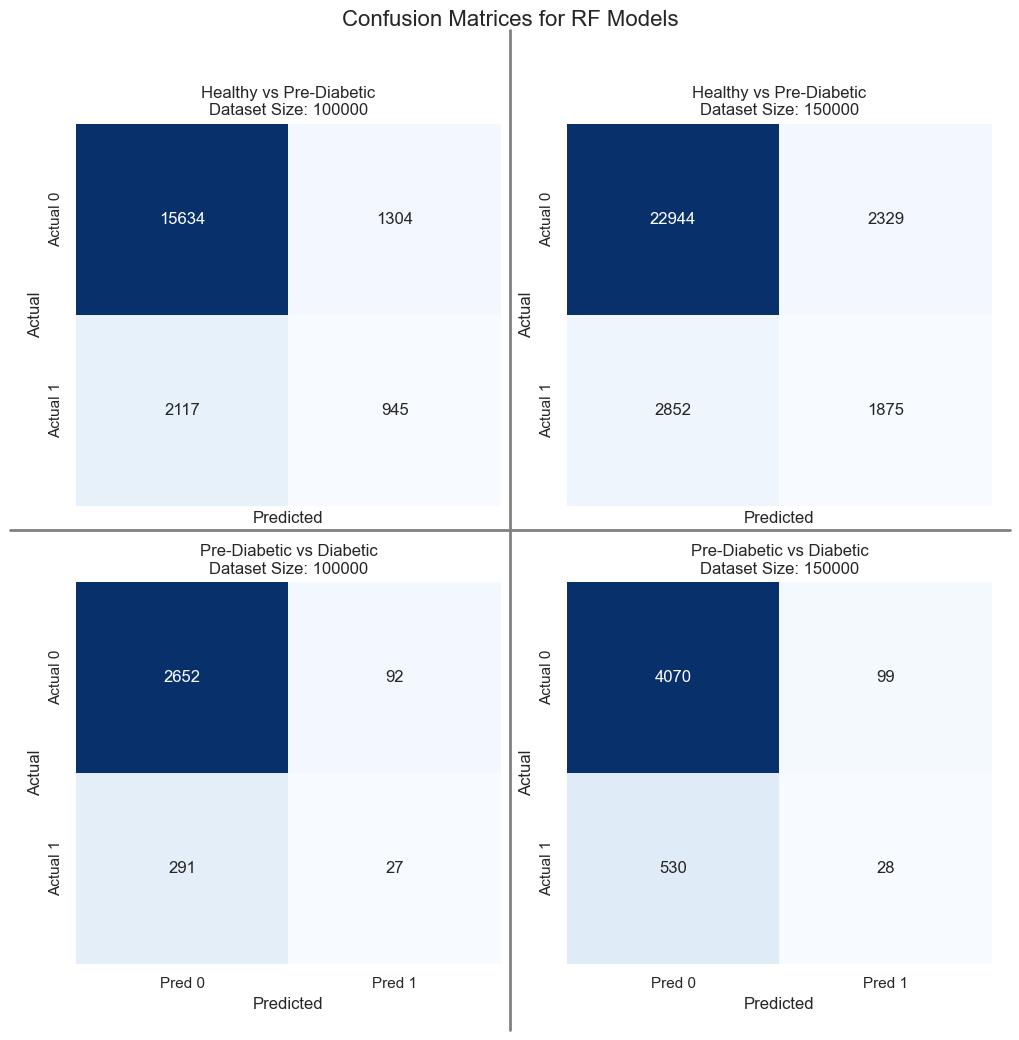

In [10]:
import re
from matplotlib.lines import Line2D
# Read in the saved CSVs with our results
df1 = pd.read_csv("RF_Healthy_vs_Pre_Diabetic.csv")
df2 = pd.read_csv("RF_Pre_Diabetic_vs_Diabetic.csv")

def parse_cm(s):
    nums = list(map(int, re.findall(r"\d+", s)))
    return np.array(nums).reshape(2, 2)

df1['Task'] = 'Healthy vs Pre-Diabetic'
df2['Task'] = 'Pre-Diabetic vs Diabetic'

df1['CM_arr'] = df1['Confusion Matrix'].apply(parse_cm)
df2['CM_arr'] = df2['Confusion Matrix'].apply(parse_cm)

# Setting up a 2×2 grid for the four matrices
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=False)

fig.add_artist(Line2D([0, 1], [0.5, 0.5], transform=fig.transFigure, color='grey', linewidth=2))
fig.add_artist(Line2D([0.5, 0.5], [0, 1], transform=fig.transFigure, color='grey', linewidth=2))

for i, (df, task) in enumerate([(df1, 'Healthy vs Pre-Diabetic'),
                                (df2, 'Pre-Diabetic vs Diabetic')]):
    for j, size in enumerate([100000, 150000]):
        ax = axes[i, j]
        row = df[df['Dataset Size'] == size].iloc[0]
        cm = pd.DataFrame(
            row['CM_arr'],
            index=['Actual 0', 'Actual 1'],
            columns=['Pred 0', 'Pred 1']
        )

        # plotting the confusion matrix with counts
        sns.heatmap(
            cm,
            annot=True, fmt="d",
            cmap="Blues",
            cbar=False,
            ax=ax
        )
        ax.set_title(f"{task}\nDataset Size: {size}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

plt.suptitle("Confusion Matrices for RF Models", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
